In [61]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter

In [62]:
include("util.j")

kfoldperm (generic function with 1 method)

In [63]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [64]:
#using Pkg
#Pkg.add("Images");

In [65]:
# Set the parameters for SLMC model #

N = 1200 # sample size
N1 = 1000; N2 = 1000;
q = 2; p = 2; K = 3
Σ = [0.3 0.1
     0.1 0.2];
β = [1.0 -1.0
     -5.0 2.0];
ϕ1 = 5.0; ϕ2 = 12.0; ϕ3 = 30.0; ν1 = 0.5; ν2 = 0.5; ν3 = 0.5; # parameter for the independent F
Λ = [3.0 0.0
     -2.0 3.0
     1.0 -2.0]; # loading matrix

# priors #
μβ = fill(0.0, p, q); Vβ =[[100.0 0.0]; [0.0 100.0]];
μΛ = fill(0.0, K, q); VΛ =[[100.0 0.0 0.0]; [0.0 100.0 0.0]; [0.0 0.0 100.0]];
νΣ = 2 * q; ΨΣ = [[1.0 0.0]; [0.0 1.0]];

In [66]:
# Generate simulation data #

Random.seed!(1234);
coords = rand(2, N);                                          # random location over unit square
X = hcat(fill(1, (N,)), rand(N));                             # design matrix
D = pairwise(Euclidean(), coords, dims = 2);                  # distance matrix
ρ1 = exp.(-ϕ1 * D); ρ2 = exp.(-ϕ2 * D);ρ3 = exp.(-ϕ3 * D);    # covariance matrix
F = [rand(MvNormal(ρ1), 1) rand(MvNormal(ρ2), 1) rand(MvNormal(ρ3), 1)]
ω = F * Λ; # latent process
Y = X * β + ω + transpose(rand(MvNormal(Σ), N));              # response matrix

In [67]:
# Some data preparations #

ordx = sortperm(coords[1, :]);                                # sort order based on the first coordinates
X_ord = X[ordx, :]; Y_ord = Y[ordx, :]; ω_ord = ω[ordx, :];   # sorted data
ω_incp_obs = ω_ord + fill(1.0, (N, 1)) * transpose(β[1, :]);  # latent process + intercept
coords_ord = coords[:, ordx];
S1_ind = sample(1:N, N1, replace = false, ordered = true);    # observed location index for 1st response
S2_ind = sample(1:N, N2, replace = false, ordered = true);    # observed location index for 2nd response
S = sort(union(S1_ind, S2_ind));                              # observed index set
M1_ind = setdiff(S, S1_ind);                                  # in S not in S1
M2_ind = setdiff(S, S2_ind);                                  # in S not in S2 
obs_ind = vcat(S1_ind, S2_ind .+ N);              # index of the observed location for all response among N locations
perm_ind = sortperm(vcat(S1_ind, S2_ind));                    # the vector of the permutation 

v1 = zeros(N); v1[S1_ind] .= 1;
v2 = zeros(N); v2[S2_ind] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
M1_Sind = findall(x -> x == 2^1, index_S[S]);                 # index of M1 among S
M2_Sind = findall(x -> x == 2^0, index_S[S]);                 # index of M2 among S

m = 10; n = length(S);                                        # number of nearest neighbor                       
NN = BuildNN(coords_ord[:, S], m, 1.0);                            # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

Lβ = cholesky(Vβ); LΛ = cholesky(VΛ);

In [27]:
# check the plot of the data 
using RCall
@rput ω_ord
@rput coords_ord
@rput S
R"""
library(MBA)
library(classInt)
library(RColorBrewer)
library(sp)
library(coda)
library(spBayes)
library(fields)

h <- 12
surf.raw1 <- mba.surf(cbind(t(coords_ord[, S]), ω_ord[S, 1]), no.X = 300, no.Y = 300, 
              exten = TRUE, sp = TRUE, h = h)$xyz.est
surf.raw2 <- mba.surf(cbind(t(coords_ord[, S]), ω_ord[S, 2]), no.X = 300, no.Y = 300, 
              exten = TRUE, sp = TRUE, h = h)$xyz.est
surf.brks <- classIntervals(c(surf.raw1[["z"]], surf.raw2[["z"]]), 500, 'pretty')$brks
col.pal <- colorRampPalette(brewer.pal(11,'RdBu')[11:1])
xlim <- c(0, 1.13)

zlim <- range(c(surf.raw1[["z"]], surf.raw2[["z"]]))

# size for the mapping of w               
width <- 360
height <- 360
pointsize <- 16

png(paste("./pics/map-w1-true.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- as.image.SpatialGridDataFrame(surf.raw1)
plot(t(coords_ord[, S]), typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("./pics/map-w2-true.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- as.image.SpatialGridDataFrame(surf.raw2)
plot(t(coords_ord[, S]), typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

"""

RObject{IntSxp}
null device 
          1 


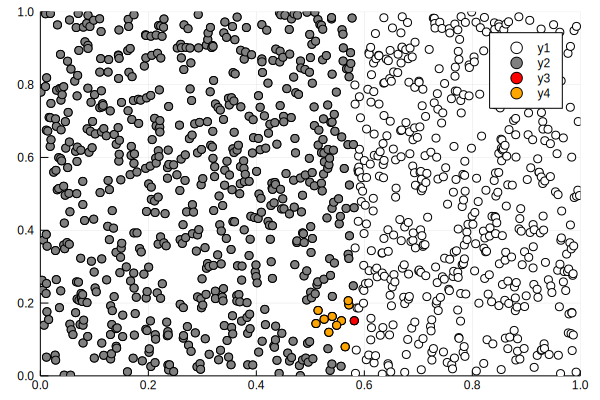

In [28]:
# check neighbors
index = 660
gr()
scatter(coords_ord[1, S], coords_ord[2, S], xlim = (0, 1), ylim = (0, 1), color = :white)
scatter!(coords_ord[1, S[1:index]], coords_ord[2, S[1:index]], color = :grey)
scatter!(coords_ord[1, S[index:index]], coords_ord[2, S[index:index]], color = :red)
scatter!(coords_ord[1, S[NN.nnIndx[NN.nnIndxLU[index]:(NN.nnIndxLU[index + 1] - 1)]]], 
    coords_ord[2, S[NN.nnIndx[NN.nnIndxLU[index]:(NN.nnIndxLU[index + 1] - 1)]]], color = :orange)

In [29]:
# preallocation #

#F = Array{Float64,2}(undef, n , 3);                           # preallocate the matrix F
μ_m1 = Array{Float64, 2}(undef, length(M1_ind), q);
μ_m2 = Array{Float64, 2}(undef, length(M2_ind), q);
nIndx = length(NN.nnIndx);
A1 = Array{Float64}(undef, nIndx); D1 = Array{Float64}(undef, n);
A2 = Array{Float64}(undef, nIndx); D2 = Array{Float64}(undef, n);
A3 = Array{Float64}(undef, nIndx); D3 = Array{Float64}(undef, n);
Ystar = vcat(Y_ord[S, :], Lβ.L \ μβ, LΛ.L \ μΛ);             # will be updated after imputing missing response
Xstar = vcat([X_ord[S, :] fill(0.0, n, K)], [inv(Lβ.L) fill(0.0, p, K)], 
    [fill(0.0, K, p) inv(LΛ.L)]);      
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = vcat(μβ, μΛ); Vγstar = fill(0.0, p + K, p + K);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p + K, p + K);

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [30]:
# Preallocation for MCMC samples and Initalization #
N_sam = 20000;
γ_sam = Array{Float64, 3}(undef, p + K, q, N_sam + 1);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam + 1);
F_sam = Array{Float64, 3}(undef, n, K, N_sam);
Y_m1_sam = Array{Float64, 2}(undef, length(M1_ind), N_sam);
Y_m2_sam = Array{Float64, 2}(undef, length(M2_ind), N_sam);

ϕ1_pick = ϕ1; ϕ2_pick = ϕ2; ϕ3_pick = ϕ3;
γ_sam[:, :, 1] = vcat([[0.0 0.0]; [0.0 0.0]], [[1.0 0.0]; [0.0 1.0]; [1.0 1.0]]);
Σ_sam[:, :, 1] = [[0.5 0.1]; [0.1 0.5]];

# first consider SLMC with fixed hyperparameter set {ψk} #
# Build the matrix Vk #
getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ1_pick, 0.5, A1, D1);
getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ2_pick, 0.5, A2, D2);
getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ3_pick, 0.5, A3, D3);

#~fix F to test the code
#vF = vcat(F[ordx[S], 1], F[ordx[S], 2], F[ordx[S], 3]) ;

In [31]:
# for loop for MCMC chain #
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    Dic_diag = Dict(2^0 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][1, 1])), 
        2^1 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][2, 2])), 
        (2^0 + 2^1)=> sparse(sqrt(inv(Σ_sam[:, :, l]))));
    invD = blockdiag([Dic_diag[i] for i in index_S if i > 0]...);
                    
    # first consider SLMC with fixed hyperparameter set {ψk} #
    # Build the matrix Vk #
    #getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ρ1_0, 0.5, A1, D1);
    #getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ρ2_0, 0.5, A2, D2);
    #getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ρ3_0, 0.5, A3, D3);

    # Build Ytilde Xtilde
    Ytilde = vcat(invD * vcat(Y_ord[S1_ind, 1] - X_ord[S1_ind, :] * γ_sam[1:p, 1, l], 
                            Y_ord[S2_ind, 2] - X_ord[S2_ind, :] * γ_sam[1:p, 2, l])[perm_ind], zeros(K * n));
    Xtilde = vcat(
             invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :, l])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, 
                            vcat(S, S .+ N, S .+ (2 * N))][perm_ind, :],
             blockdiag(
             Diagonal(1 ./ sqrt.(D1)) * sparse(nnIndx_row, nnIndx_col, vcat(-A1, ones(n))),
             Diagonal(1 ./ sqrt.(D2)) * sparse(nnIndx_row, nnIndx_col, vcat(-A2, ones(n))),
             Diagonal(1 ./ sqrt.(D3)) * sparse(nnIndx_row, nnIndx_col, vcat(-A3, ones(n)))))
                
    # use LSMR to generate sample of F #       
    nsam = length(Ytilde);
    F_sam[:, :, l] = reshape(lsmr(Xtilde, Ytilde + rand(Normal(), nsam)), :, K);
                    
    # impute missing response over S#
    Xstar[1:n, (p + 1):(p + K)] = F_sam[:, :, l];        # update matrix Xstar with F
    mul!(μ_m1, Xstar[M1_Sind, :], γ_sam[:, :, l]);
    mul!(μ_m2, Xstar[M2_Sind, :], γ_sam[:, :, l]);

    Y_m1_sam[:, l] = μ_m1[:, 1] + (Σ_sam[1, 2, l] / Σ_sam[2, 2, l]) * 
            (Y_ord[M1_ind, 2] - μ_m1[:, 2]) + 
            rand(Normal(0, sqrt(Σ_sam[1, 1, l] - Σ_sam[1, 2, l]^2 / Σ_sam[2, 2, l])), length(M1_ind));
    Y_m2_sam[:, l] = μ_m2[:, 2] + (Σ_sam[2, 1, l] / Σ_sam[1, 1, l]) * 
            (Y_ord[M2_ind, 1] - μ_m2[:, 1]) + 
            rand(Normal(0, sqrt(Σ_sam[2, 2, l] - Σ_sam[2, 1, l]^2 / Σ_sam[1, 1, l])), length(M2_ind)); # improve?...
                    
    # use MNIW to sample γ Σ #
    Ystar[M1_Sind, 1] = Y_m1_sam[:, l];              # update Ystar with imputed response
    Ystar[M2_Sind, 2] = Y_m2_sam[:, l]; 
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    Y_Xm = BLAS.gemm('N', 'N', -1.0, Xstar, μγstar) + Ystar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam[:, :, l + 1] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam[:, :, l + 1] = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) * 
                    cholesky(Σ_sam[:, :, l + 1]).U + μγstar;          # sample γ  
    
    # force positive                
    #if γ_sam[p + 1, 1, l + 1] < 0 
    #    γ_sam[(p + 1), :, l + 1] = -γ_sam[(p + 1), :, l + 1]
    #end
    #if γ_sam[p + 2, 1, l + 1] < 0 
    #    γ_sam[(p + 2), :, l + 1] = -γ_sam[(p + 2), :, l + 1]
    #end
    #if γ_sam[p + 3, 1, l + 1] < 0 
    #    γ_sam[(p + 3), :, l + 1] = -γ_sam[(p + 3), :, l + 1]
    #end
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 1:15:57


Posterior prediction

In [33]:
# prediction preparison
N_pre_burn = Integer(trunc(N_sam / 2));
M_ind = setdiff(1:N, S); NM = length(M_ind)
F_M_sam = Array{Float64, 3}(undef, NM, K, N_sam - N_pre_burn + 1);
Y_M_sam = Array{Float64, 3}(undef, NM, q, N_sam - N_pre_burn + 1);

# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
"""
@rget nn_mod_ho

MnnIndxLU = collect(1:m:(NM * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
Atilde1 = Array{Float64}(undef, NM * m); Dtilde1 = Array{Float64}(undef, NM);
Atilde2 = Array{Float64}(undef, NM * m); Dtilde2 = Array{Float64}(undef, NM);
Atilde3 = Array{Float64}(undef, NM * m); Dtilde3 = Array{Float64}(undef, NM);
getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, ϕ1_pick, 0.5, Atilde1, Dtilde1)
getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, ϕ2_pick, 0.5, Atilde2, Dtilde2)
getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, ϕ3_pick, 0.5, Atilde3, Dtilde3)
AtildeM1 = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde1, NM, n);
AtildeM2 = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde2, NM, n);
AtildeM3 = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde3, NM, n);

In [34]:
for i in N_pre_burn:N_sam
    # update F
    F_M_sam[:, 1, (i - N_pre_burn + 1)] = AtildeM1 * F_sam[:, 1, i] + sqrt.(Dtilde1) .* rand(Normal(), NM)
    F_M_sam[:, 2, (i - N_pre_burn + 1)] = AtildeM2 * F_sam[:, 2, i] + sqrt.(Dtilde2) .* rand(Normal(), NM)
    F_M_sam[:, 3, (i - N_pre_burn + 1)] = AtildeM3 * F_sam[:, 3, i] + sqrt.(Dtilde3) .* rand(Normal(), NM)
    # update Y
    Y_M_sam[:, :, (i - N_pre_burn + 1)] = X_ord[M_ind, :] * γ_sam[1:p, :, i + 1] + 
        F_M_sam[:, :, (i - N_pre_burn + 1)] *  γ_sam[(p + 1):(p + K), :, i + 1] + 
        transpose(rand(MvNormal(Σ_sam[:, :, i + 1]), NM))
end

# MCMC Chain check

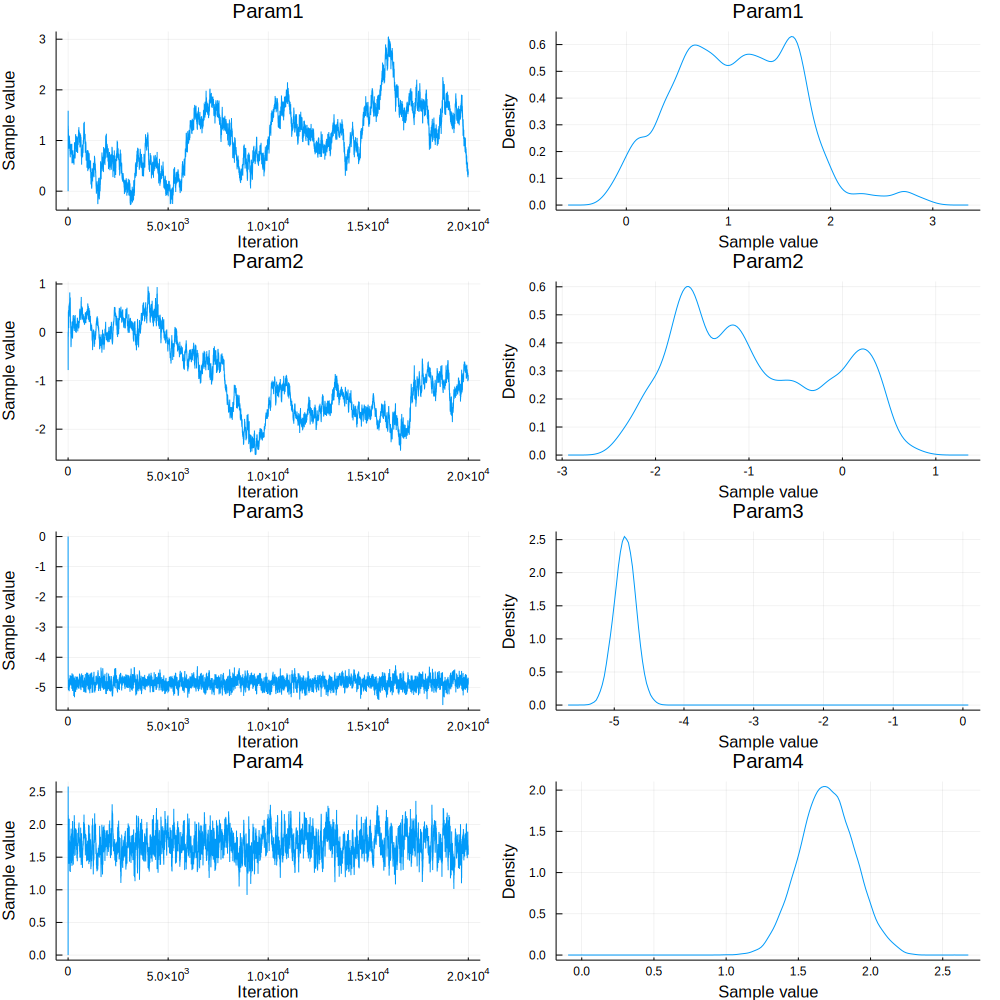

In [35]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[1, 1, :], γ_sam[1, 2, :], γ_sam[2, 1, :], γ_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [36]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat(γ_sam[3, 1, :], γ_sam[3, 2, :], γ_sam[4, 1, :], γ_sam[4, 2, :], 
    γ_sam[5, 1, :], γ_sam[5, 2, :]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

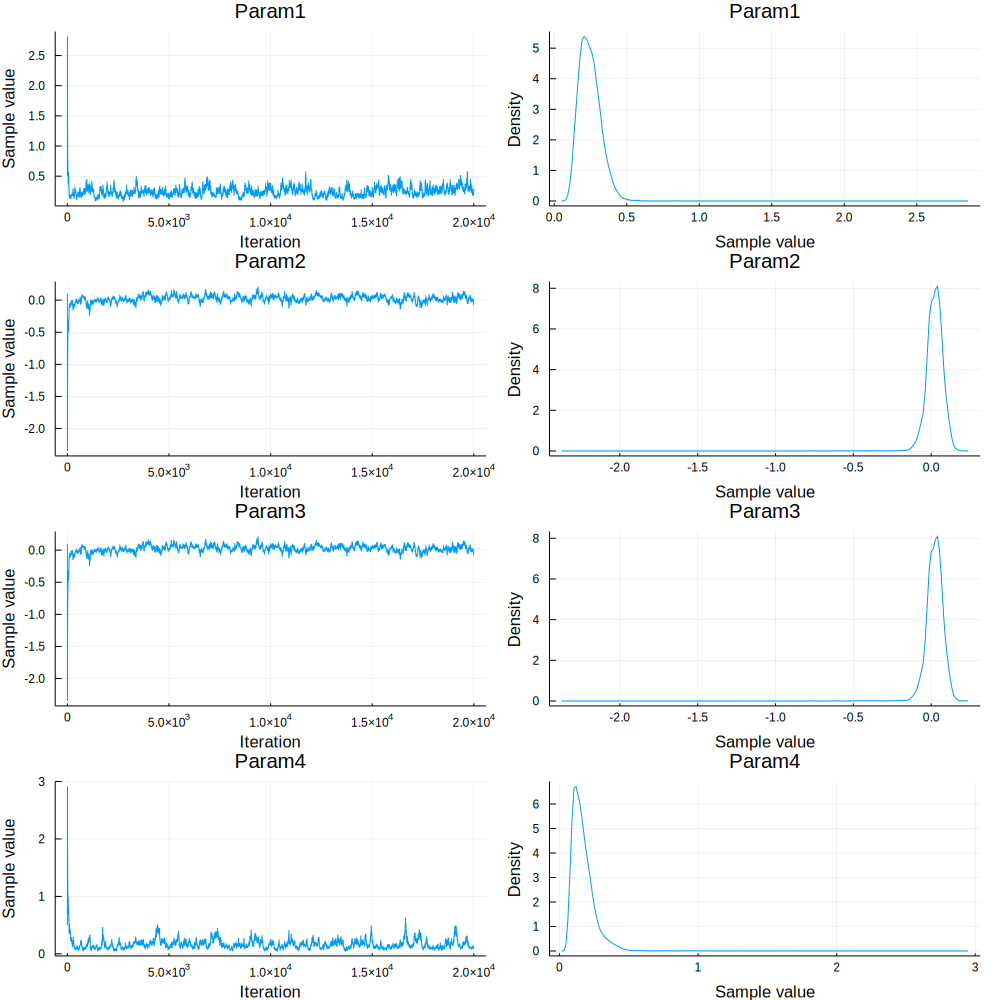

In [37]:
truncindex = 1;#Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

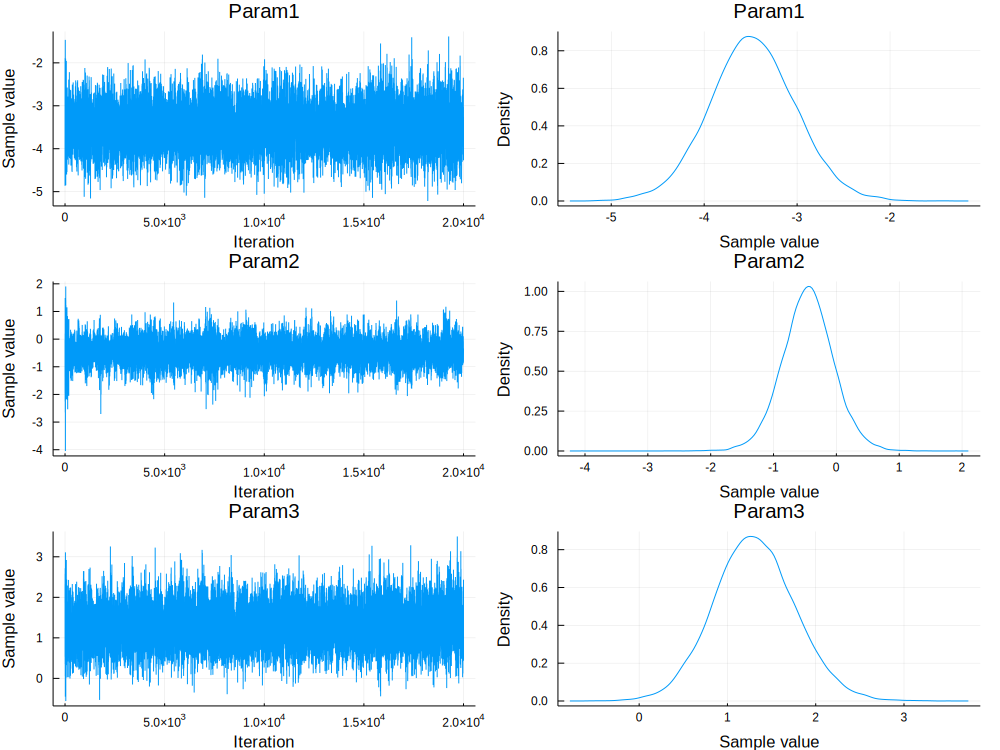

In [38]:
ω_incp_obs_pos_sam = Array{Float64, 3}(undef, n, q, N_sam);
lll = fill(1.0, (n, 1));
for i in 1:N_sam
    ω_incp_obs_pos_sam[:, :, i] = F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1] + 
                     lll * transpose(γ_sam[1, :, i + 1]);
end
truncindex = 1;#Integer(trunc(N_sam / 2));
ω_incp_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex  + 1, 3, 1);
ω_incp_pos_sam[:, :, 1] = hcat(ω_incp_obs_pos_sam[1, 1, truncindex:N_sam], 
    ω_incp_obs_pos_sam[1, 2, truncindex:N_sam], ω_incp_obs_pos_sam[200, 1, truncindex:N_sam]);
ω_incp_chain = Chains(ω_incp_pos_sam);
pΣ = plot(ω_incp_chain)

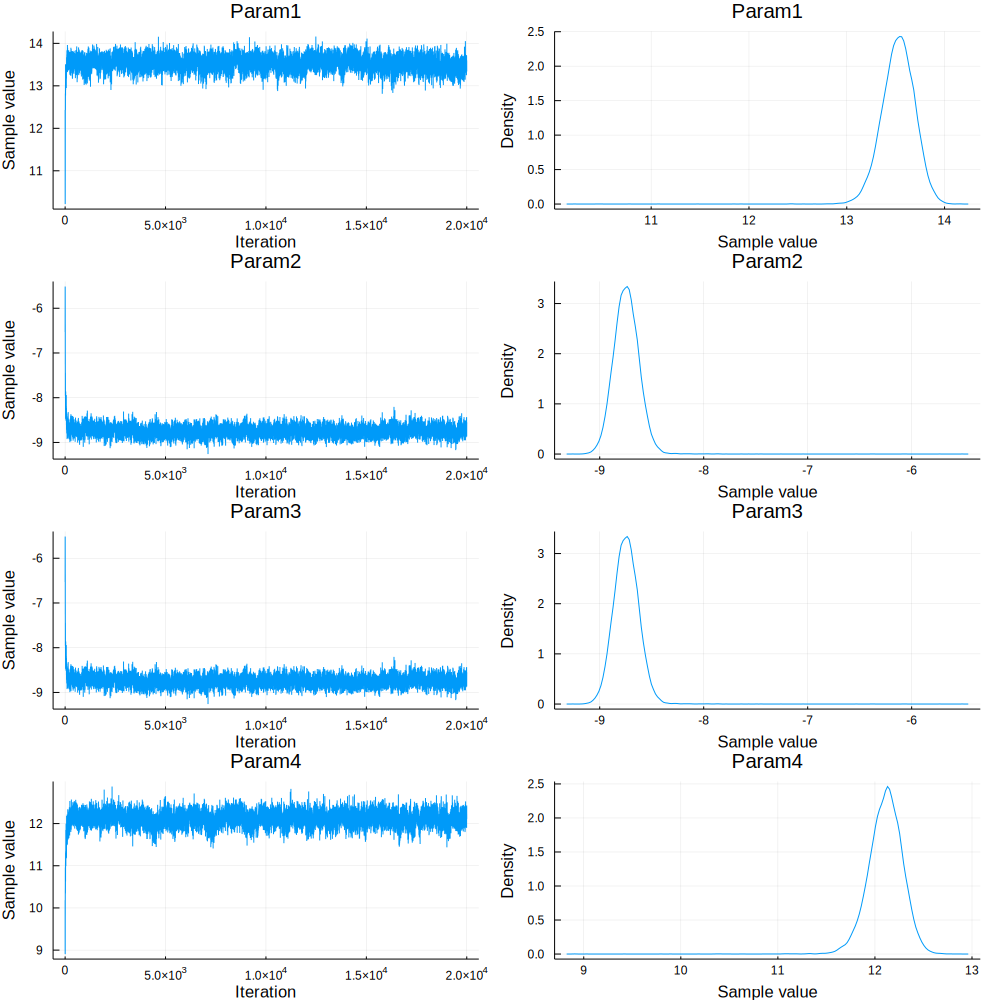

In [39]:
# check the variance covariance across latent process
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov(F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

In [50]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
 13.4299   -8.69258
 -8.69258  12.2167 

# Posterior Inference 

In [42]:
N_Inf_burn = Integer(trunc(N_sam / 2));
ω_incp_obs_pos_qt = Array{Float64, 3}(undef, n, q, 3);
for j in 1:q
    for i in 1:n
        ω_incp_obs_pos_qt[i, j, :] = quantile(ω_incp_obs_pos_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975])
    end
end
# count the covarage of 95% CI #
count_ω_incp = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        ((ω_incp_obs_pos_qt[i, j, 1] < ω_incp_obs[S[i], j]) && 
            (ω_incp_obs_pos_qt[i, j, 3] > ω_incp_obs[S[i], j]))
    end
end
count_ω_incp

2-element Array{Float64,1}:
 1112.0
 1096.0

In [43]:
count_ω_incp ./ n

2-element Array{Float64,1}:
 0.9553264604810997
 0.9415807560137457

In [56]:
summary_table = Array{Float64, 2}(undef, (p - 1) * q + (q * q - 1) * 2, 5);
summary_table[1, :] = vcat(β[2, 1], mean(γ_sam[2, 1, N_Inf_burn:(N_sam + 1)]),
    quantile(γ_sam[2, 1, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[2, 2], mean(γ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(γ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(Σ[1, 1], mean(Σ_sam[1, 1, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[1, 1, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(Σ[1, 2], mean(Σ_sam[1, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[1, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[2, 2], mean(Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(covω[1, 1], mean(cov_pos_sam[N_Inf_burn:N_sam, 1, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 1, 1], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(covω[1, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 2, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 2, 1], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[2, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 4, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 4, 1], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3 );
rnames = ["β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              |   true |   mean | median |   2.5% |  97.5% |
|--------------|--------|--------|--------|--------|--------|
|      β[2, 1] |   -5.0 | -4.847 | -4.846 | -5.151 | -4.544 |
|      β[2, 2] |    2.0 |    1.7 |  1.699 |  1.336 |  2.078 |
|      Σ[1, 1] |    0.3 |  0.246 |  0.237 |   0.13 |  0.405 |
|      Σ[1, 2] |    0.1 |  0.022 |  0.026 | -0.084 |  0.116 |
|      Σ[2, 2] |    0.2 |   0.17 |  0.151 |  0.072 |  0.375 |
| cov(ω)[1, 1] |  13.43 | 13.525 | 13.531 | 13.189 | 13.833 |
| cov(ω)[1, 2] | -8.693 | -8.742 | -8.746 | -8.968 | -8.508 |
| cov(ω)[2, 2] | 12.217 | 12.107 | 12.117 |  11.75 | 12.427 |


In [57]:
# posterior prediction check #
N_Inf_burn = 1;
Y_M_pos_qt = Array{Float64, 3}(undef, NM, q, 3);
Y_M_pos_mean = Array{Float64, 2}(undef, NM, q);
for j in 1:q
    for i in 1:NM
        Y_M_pos_qt[i, j, :] = quantile(Y_M_sam[i, j, :], [0.025, 0.5, 0.975]);
        Y_M_pos_mean[i, j] = mean(Y_M_sam[i, j, :])
    end
end
# count the covarage of 95% CI #
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        ((Y_M_pos_qt[i, j, 1] < Y_ord[M_ind[i], j]) && 
            (Y_M_pos_qt[i, j, 3] > Y_ord[M_ind[i], j]))
    end
end
count_Y_M

2-element Array{Float64,1}:
 35.0
 35.0

In [58]:
count_Y_M ./ NM

2-element Array{Float64,1}:
 0.9722222222222222
 0.9722222222222222

In [60]:
# calculate root mean square predictive error #
MSPE = mean((Y_ord[M_ind, :] - Y_M_pos_mean).^2)
RMSPE = sqrt(MSPE); RMSPE

1.9426073980012208

# Plot the latent process + intercept

In [59]:
# check the plot of the data 
using RCall
@rput ω_incp_obs
@rput coords_ord
@rput S
@rput ω_incp_obs_pos_qt
R"""
library(MBA)
library(classInt)
library(RColorBrewer)
library(sp)
library(coda)
library(spBayes)
library(fields)

h <- 12
surf.raw1 <- mba.surf(cbind(t(coords_ord[, S]), ω_incp_obs[S, 1]), no.X = 300, no.Y = 300, 
              exten = TRUE, sp = TRUE, h = h)$xyz.est
surf.raw2 <- mba.surf(cbind(t(coords_ord[, S]), ω_incp_obs[S, 2]), no.X = 300, no.Y = 300, 
              exten = TRUE, sp = TRUE, h = h)$xyz.est

surf.pos1 <- mba.surf(cbind(t(coords_ord[, S]), ω_incp_obs_pos_qt[, 1, 2]), no.X = 300, no.Y = 300, 
              exten = TRUE, sp = TRUE, h = h)$xyz.est
surf.pos2 <- mba.surf(cbind(t(coords_ord[, S]), ω_incp_obs_pos_qt[, 2, 2]), no.X = 300, no.Y = 300, 
              exten = TRUE, sp = TRUE, h = h)$xyz.est

surf.brks <- classIntervals(c(surf.raw1[["z"]], surf.raw2[["z"]]), 500, 'pretty')$brks
col.pal <- colorRampPalette(brewer.pal(11,'RdBu')[11:1])
xlim <- c(0, 1.13)

zlim <- range(c(surf.raw1[["z"]], surf.raw2[["z"]], surf.pos1[["z"]], surf.pos2[["z"]]))

# size for the mapping of w               
width <- 360
height <- 360
pointsize <- 16

png(paste("./pics/map-w1_incp-true_fix.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- as.image.SpatialGridDataFrame(surf.raw1)
plot(t(coords_ord[, S]), typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("./pics/map-w2_incp-true_fix.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- as.image.SpatialGridDataFrame(surf.raw2)
plot(t(coords_ord[, S]), typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("./pics/map-w1_incp-posm_fix.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- as.image.SpatialGridDataFrame(surf.pos1)
plot(t(coords_ord[, S]), typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("./pics/map-w2_incp-posm_fix.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- as.image.SpatialGridDataFrame(surf.pos2)
plot(t(coords_ord[, S]), typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

"""

RObject{IntSxp}
null device 
          1 


![w1]<img src="./pics/map-w1_incp-true_fix.png"> 
![w1_pos]<img src="./pics/map-w1_incp-posm_fix.png"> 
![w2]<img src="./pics/map-w2_incp-true_fix.png">
![w2_pos]<img src="./pics/map-w2_incp-posm_fix.png"> 